In [2]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.initializers import glorot_uniform
from imblearn.over_sampling import SMOTE
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
import librosa
import os
import json

In [3]:
SAMPLE_RATE = 48000 # 48kHz
DATASET_PATH = "../../ABA-Audio-Data/Labelled/"
JSON_PATH = "../../ABA-Audio-Data/data.json"
MELSPECT_OR_MFCC = "melspect" # Choose "melspect" or "mfcc" for train on either data type.
N_MFCC = 25

In [4]:
# This structure is used to save and export the data.
data = {
    # Mapping the different genre lables onto numbers.
    "mapping": [],
    
    # Either the MFCC data or the MELSPECT data, depending on mode.
    "all_audio": [],
    
    # The targets. Each value in "labels" refers to the index of the
    # "labels" list. 
    "labels": []
}

for i, (dirpath, dirnames, filenames) in enumerate(os.walk(DATASET_PATH)):
    if dirpath is not DATASET_PATH:
        # This gives us dirpath ~/none and ~/whine.
        dirpath_components = dirpath.split('/')
        label = dirpath_components[-1]
        data["mapping"].append(label)
        print(f"Currently processing label: {label}")
        
        for j, file in enumerate(filenames):
            # Load audio file.
            file_path = os.path.join(dirpath, file)
            signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
            
            # The last second of the video is usually not a full second, and therefore produces
            # an nparray that is abnormal in shape to the rest of the arrays. All the arrays
            # need to be the same shape, this pads the abnormal arrays with empty data.
            if (len(signal) < SAMPLE_RATE):
                signal = np.pad(signal, (0, SAMPLE_RATE-len(signal)))
                if (signal.shape != (48000,)):
                    print("Error, bad signal shape.")
            
            if (MELSPECT_OR_MFCC == "melspect"):
                curr_melspect = librosa.feature.melspectrogram(y=signal)
                data["all_audio"].append(curr_melspect.tolist())
            elif (MELSPECT_OR_MFCC == "mfcc"):
                curr_mfcc = librosa.feature.mfcc(y=signal, sr=SAMPLE_RATE, n_mfcc=N_MFCC)
                curr_mfcc = curr_mfcc.T
                data["all_audio"].append(curr_mfcc.tolist())
            else:
                exit('Set MELSPECT_OR_MFCC to either "melspect" or "mfcc".')
            
            data["labels"].append(i-1)
            
            if (j % 750 == 0):
                print(f"Working file path: {file_path} {j}")
            
            final = j
        else:
            print(final)

print("DONE")

Currently processing label: none
Working file path: ../../ABA-Audio-Data/Labelled/none\10chunk100.wav 0
Working file path: ../../ABA-Audio-Data/Labelled/none\16chunk130.wav 750
Working file path: ../../ABA-Audio-Data/Labelled/none\1chunk1210.wav 1500
Working file path: ../../ABA-Audio-Data/Labelled/none\1chunk1887.wav 2250
Working file path: ../../ABA-Audio-Data/Labelled/none\1chunk2566.wav 3000
Working file path: ../../ABA-Audio-Data/Labelled/none\1chunk687.wav 3750
Working file path: ../../ABA-Audio-Data/Labelled/none\22chunk100.wav 4500
Working file path: ../../ABA-Audio-Data/Labelled/none\3chunk81.wav 5250
Working file path: ../../ABA-Audio-Data/Labelled/none\7chunk44.wav 6000
6582
Currently processing label: whine
Working file path: ../../ABA-Audio-Data/Labelled/whine\10chunk0.wav 0
Working file path: ../../ABA-Audio-Data/Labelled/whine\16chunk183.wav 750
988
DONE


In [5]:
with open(JSON_PATH, "w") as fp:
    json.dump(data, fp, indent=4)

In [6]:
# Use the output of this statment for the input of "input_shape" in the first
# Conv2D layer in the model blow with an added 3rd dimension, like (x, y, 1).
print(np.array(data["all_audio"][0]).shape)

(128, 94)


In [7]:
X = np.array(data["all_audio"])
y = np.array(data["labels"])
X, y = shuffle(X, y)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.5)

X_val, X_test, y_val, y_test = train_test_split(X_test,
                                                y_test,
                                                test_size=0.10)

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 94, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 92, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 46, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 44, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 22, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 20, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 35840)             0

In [9]:
print(X_train.shape)
print(y_train.shape)

(3786, 128, 94)
(3786,)


In [10]:
# Reset Weights and Biases of model for retraining.
for i, layer in enumerate(model.layers):
    if hasattr(model.layers[i], 'kernel_initializer') and \
            hasattr(model.layers[i], 'bias_initializer'):
        weight_initializer = model.layers[i].kernel_initializer
        bias_initializer = model.layers[i].bias_initializer
        
        old_weights, old_biases = model.layers[i].get_weights()
        
        model.layers[i].set_weights([
            weight_initializer(shape=old_weights.shape),
            bias_initializer(shape=old_biases.shape)
        ])

In [11]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.01),
              metrics='accuracy')

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
119/119 [==============================] - 24s 183ms/step - loss: 2.2153 - accuracy: 0.8584 - val_loss: 0.6466 - val_accuracy: 0.8685
Epoch 2/10
119/119 [==============================] - 19s 160ms/step - loss: 0.4620 - accuracy: 0.8685 - val_loss: 0.5433 - val_accuracy: 0.8685
Epoch 3/10
119/119 [==============================] - 21s 173ms/step - loss: 0.4258 - accuracy: 0.8700 - val_loss: 0.4813 - val_accuracy: 0.8632
Epoch 4/10
119/119 [==============================] - 19s 161ms/step - loss: 0.4793 - accuracy: 0.8645 - val_loss: 0.3670 - val_accuracy: 0.8703
Epoch 5/10
119/119 [==============================] - 21s 174ms/step - loss: 0.3718 - accuracy: 0.8716 - val_loss: 0.3760 - val_accuracy: 0.8697
Epoch 6/10
119/119 [==============================] - 21s 174ms/step - loss: 0.3489 - accuracy: 0.8716 - val_loss: 0.4121 - val_accuracy: 0.8688
Epoch 7/10
119/119 [==============================] - 22s 188ms/step - loss: 0.2967 - accuracy: 0.8724 - val_loss: 0.3135 - val_ac

In [12]:
model.save('whine-cry.model')

INFO:tensorflow:Assets written to: whine-cry.model\assets


INFO:tensorflow:Assets written to: whine-cry.model\assets


12/12 - 1s - loss: 0.4421 - accuracy: 0.8391 - 745ms/epoch - 62ms/step


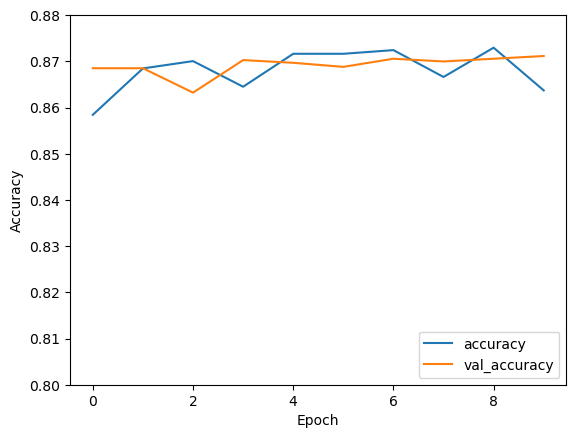

In [13]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.8, .88)
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)